<h1>Классификация текста</h1>

<h4>Условие</h4>

Набор данных
Набор данных содержит множество сообщений (файлов).
Если в названии файла есть подстрока legit, то это хорошее сообщение.
Если в названии файла есть подстрока spmsg, то это спам.
Сообщения состоят из заголовка и тела сообщения.
Каждое слово было заменено на определённое число.


<h4>Задание</h4>

1. Придумайте два способа <b>учёта заголовка и тела сообщения при векторизации.</b>. Например: учитывать одинаково или учитывать раздельно.

2. Придумайте два способа <b>векторизации текста</b>. Например, для каждого слова создать признак: встретилось или нет, или сколько раз встретилось.

3. Табличный набор данных должен быть в <b>разреженном виде</b>.

4. Постройте Наивный байесовский классификатор на наборе данных.

5. Постройте ROC кривую. Вычислите для неё AUC. Выберете наилучшую комбинацию из первых двух пунктов относительно метрики AUC. График не должен состоять из “одной точки”.

6. Измените априорное распределение для выбранной модели таким образом, чтобы число хороших сообщений классифицированных как спам равнялось нулю. При этом точность должна быть максимально возможной. Постройте график зависимости точности классификации от изменения априорного распределения в логарифмированном пространстве.


In [90]:
#TASK0. Чтение данных
from os import listdir
import pandas as pd

list = listdir('data5\messages/') #считываем названия файлов в лист
texts = []; #сюда сложим тексты всех смс с маркером спам или нет 
for file in list:
    with open('data5\messages/' + file, 'r') as reader:
        text = [];
        for str in reader.readlines():
            text.append(str[:-1])
#TASK1
#Придумайте два способа учёта заголовка и тела сообщения при векторизации. Например: учитывать одинаково или учитывать раздельно.
#Учет по раздельности (отдельно учитываем text[0] и text[1])
        texts.append({
            #find - возвращает позицию если имеется подстрока иначе -1
            'legit' : file.find('legit') >= 0 if 1 else 0, 
            #Текст вида массива из ['Subject: слова через пробел'; '', 'Основной текст']
            #сразу выкинем лишний разделитель и subject
            'text' : [text[0][9:], text[2]]
            #Учет по-раздельности - 1 вариант
            #Получаем обращение к заголовку по texts.text[0] и по тексту texts.text[1]
            #Учет вместе - 0 вариант
            #texts.text[0] + ' ' + texts.text[1]
        })

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

#Вспомогательная функция позволяющая расставлять id-шники и считать количество встреч
#part - место поиска, остальное значения полученные на предыдущих строках
#раздаем каждому слову айди исчитаем количество его встреч в данном тексте
def build_wid_entr(part, wordId, entry, nextId):
    if len(part) == 0: return wordId, entry, nextId;
    for word in part.split():
        if int(word) not in wordId:
            wordId[int(word)] = nextId
            nextId += 1
        id = wordId[int(word)]
        entry[id] = entry.get(id, 0) + 1
    return wordId, entry, nextId

#TASK2
#Придумайте два способа векторизации текста.
#Например, для каждого слова создать признак: встретилось или нет, или сколько раз встретилось.

def task2fun(entry, i, TASK2, row_ind, col_ind, val, rowShape, colShape, shift):
    for icol, cnt in entry.items():
        row_ind.append(i)
        col_ind.append(icol + shift)
        rowShape = max(rowShape, i + 1)
        colShape = max(colShape, icol + shift + 1)
        if TASK2 == 'int': #Сколько раз встретилось
            val.append(cnt)
        elif TASK2 == 'bool': #Встретилось или нет
            val.append(1)
    return (row_ind, col_ind, val, rowShape, colShape);

def build_matrix(TASK1, TASK2, texts):
    row_ind = []; col_ind = []; val = []; 
    rowShape = 0; colShape = 0; nextId = 0;
    wordId = {}
    y = [] # переменная класса - столбик legit/spam

    for i, text in enumerate(texts): #i -номер текста 
        # матрица где 0 это спам иначе 1
        y.append(1 if text['legit'] else 0)
        entry = {}
        entry_title = {}
        #УЧЕТ ПО TASK1
        if (TASK1): 
            #1 - Учет по раздельности
            wordId, entry_title, nextId = build_wid_entr(
                text['text'][0], wordId, entry_title, nextId);
            wordId, entry, nextId = build_wid_entr(
                text['text'][1], wordId, entry, nextId);
        else :
            #0 - Учет вместе
            str = text['text'][0] + ' ' + text['text'][1];
            wordId, entry, nextId = build_wid_entr(str, wordId, entry, nextId)
        #УЧЕТ ПО TASK2(0)
        row_ind, col_ind, val, rowShape, colShape = task2fun(entry, i, TASK2, row_ind, col_ind, val, rowShape, colShape, 0)
        #УЧЕТ ПО TASK2(1)
        row_ind, col_ind, val, rowShape, colShape = task2fun(entry_title, i, TASK2, row_ind, col_ind, val, rowShape, colShape, len(wordId.keys()))

#TASK3 Табличный набор данных должен быть в разреженном виде.
    #csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
    #where data, row_ind and col_ind satisfy the relationship a[row_ind[k], col_ind[k]] = data[k].
    return csr_matrix((np.array(val), (np.array(row_ind), np.array(col_ind))), shape=(rowShape, colShape), dtype=int).toarray(), np.array(y)


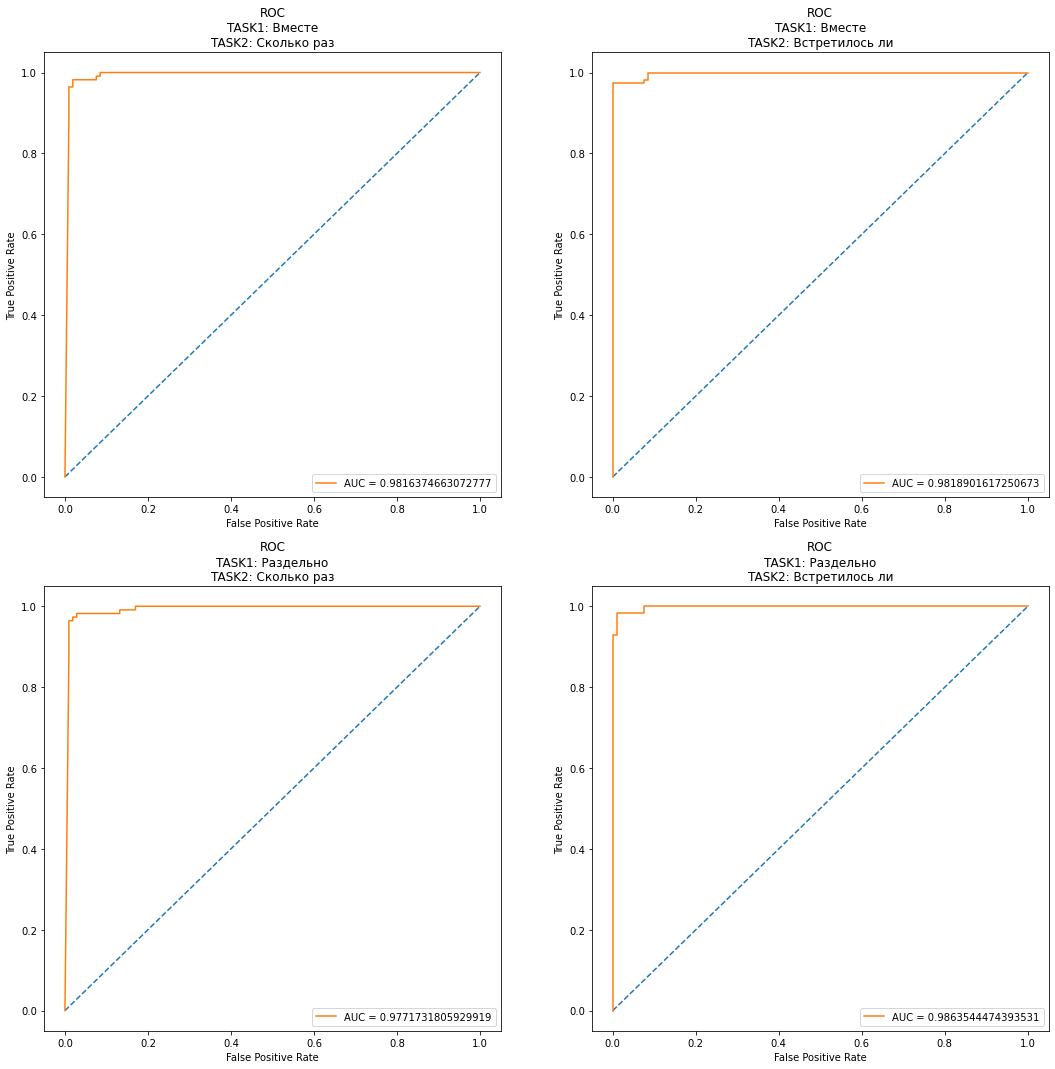

In [92]:
from sklearn.naive_bayes import MultinomialNB
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 18)) #Создадим графики для каждой комбинации

#Рассмоттрим 4 случая 
for i, TASK1 in enumerate([0, 1]):
    for j, TASK2 in enumerate(['int', 'bool']):
        X, Y = build_matrix(TASK1, TASK2, texts) # X - параметры, характеристики (записанная в разреженную матрицу)
        #Y - переменная класса, то что будем предскащывать 
        train_X, test_X, train_Y, test_Y = train_test_split(
            X, Y, test_size=0.2, random_state=0)

#TASK4. Постройте Наивный байесовский классификатор на наборе данных.
        #Теорема Байеса - формула для вычисления условной вероятности
        #Условная вероятность - вероятность наступления одного события, при условии что другое
        #событие уже произошло. P(y|X)= P(X|y)P(y)/P(X)
        #наивный потому что считает что вклад каждой характеристики равный и независимый
        model = MultinomialNB()
        model.fit(train_X, train_Y)
        predict = model.predict(test_X)
        prediction = model.predict_proba(test_X)[::, 1] #выдать «степень уверенности» в ответе(вероятность)
#TASK5. Постройте ROC кривую, вычислите ее AUC (площадь под кривой, чем ближе к 1 тем лучше модель)
#ROC - насколько модель справляется с классификацией как хорошее сообщение/спам
        fpr, tpr, _ = roc_curve(test_Y, prediction)
        auc = roc_auc_score(test_Y, predict)
        ax[i][j].plot([0, 1], [0, 1], linestyle='--')
        ax[i][j].plot(fpr, tpr, label=f'AUC = {auc}')
        t1 = ''; t2 = '';
        if (TASK1) : t1 = 'Раздельно'
        else : t1 = 'Вместе'
        if (TASK2 == 'int') : t2 = 'Сколько раз'
        else : t2 = 'Встретилось ли'
        ax[i][j].set_title(f'ROC\nTASK1: {t1}\nTASK2: {t2}')
            #TASK1  = 1 раздельно 0 слитно
        ax[i][j].set_ylabel('True Positive Rate') #истинно положительный результат
        ax[i][j].set_xlabel('False Positive Rate') #истинно ложный результат
        ax[i][j].legend()
plt.show()
#НАИЛУЧШАЯ КОМБИНАЦИЯ: TASK1 = 0(вместе) TASK2 = bool(встречалось ли)

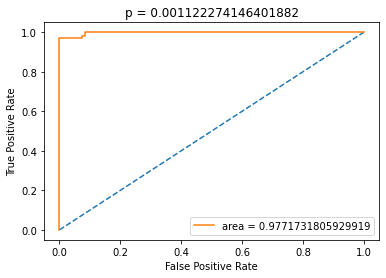

In [86]:
X, Y = build_matrix(0, 'bool', texts) # Выбранная модель
#TASK6
#априорное распределение вероятностей неопределённой величины p —
#распределение вероятностей, которое выражает предположения о p до учёта экспериментальных данных
#у классификатора имеется некоторый параметр, варьируя который,
#мы будем получать то или иное разбиение на два класса.
#Покрутим его и аосмотрим где значения лучше
p = 10**-7
pс = 0 ; fprc = 0 ; tprс = 0 ; aucc = 0 #curmodel max
#Чтобы хорошие сообщения не классифицировались как спам надо повысть FPR(чувствительность)
while p < 0.1:
    model = MultinomialNB(fit_prior=False, class_prior=[p, 1 - p])
    #Априорные вероятности классов. Если указано, априоры не корректируются в соответствии с данными.
    model.fit(train_X, train_Y)
    prediction = model.predict_proba(test_X)[:, 1]
    predict = model.predict(test_X)
    fpr, tpr, _ = roc_curve(test_Y, prediction)
    auc = roc_auc_score(test_Y, predict)
    if auc > aucc :
        fprc = fpr
        tprc = tpr
        aucc = auc
        pc = p
    p = p * 1.5

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fprc, tprc, label=f'area = {aucc}')
plt.title(f'p = {pc}')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()


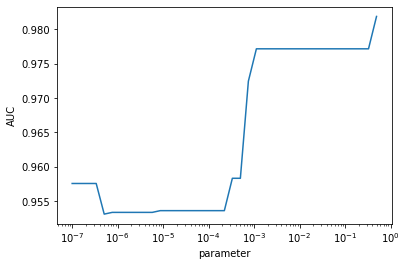

In [89]:
#TASK7
X, Y = build_matrix(0, 'bool', texts)
train_X, test_X, train_Y, test_Y = train_test_split(
    X, Y, test_size=0.2, random_state=0)
arr_auc = []
arr_p = []
p = 10**-7
while p < 0.5:
    arr_p.append(p)
    model = MultinomialNB(fit_prior=False, class_prior=[p, 1 - p])
    #Априорные вероятности классов. Если указано, априоры не корректируются в соответствии с данными.
    model.fit(train_X, train_Y)
    prediction = model.predict_proba(test_X)[:, 1]
    predict = model.predict(test_X)
    fpr, tpr, _ = roc_curve(test_Y, prediction)
    arr_auc.append(roc_auc_score(test_Y, predict))
    p = p * 1.5

plt.xscale('log')
plt.plot(arr_p, arr_auc)
plt.ylabel('AUC')
plt.xlabel('parameter')
plt.show()
